# AdTech CTR prediction
**Aprendizaje de Máquina - CEIA - FIUBA**

Estamos con datos de una empresa de publicidad digital en tiempo real llamada **AdTech Solutions Inc.**

Cuando se presenta un espacio de publicidad en una página web, en el instante exacto en que un usuario ingresa al sitio, esta empresa debe decidir en milisegundos qué anuncio mostrar y, lo más importante, cuánto dinero ofertar por esa impresión.

Predecir correctamente el CTR (Click-Through Rate) de un anuncio es el problema crítico de la empresa. 

Dado que se busca optimizar el Retorno de Inversión (ROI), no nos basta con una clasificación binaria (Clic / No Clic).

Necesitamos probabilidades exactas. ¿Por qué?

- Si el modelo predice un 90% de probabilidad de clic, el sistema ofertará agresivamente (ej. $2.00 USD).
- Si la probabilidad real era solo del 20%, habremos pagado de más por un usuario que probablemente nos ignorará.

El cálculo de la oferta máxima a obtener es:

Oferta Máxima = Valor del Clic * $P(Clic)$

- Si el valor de un clic es $5.00 y el modelo dice que P(Clic)=0.8, ofertamos 4.00.

- Si el modelo está descalibrado y la realidad es P(Clic)=0.2, debimos ofertar $1.00. ¡Estamos perdiendo 3.00 por impresión!

Equivocarnos en la predicción de P(Clic) puede costar caro a la empresa. Los clientes de la empresa esperan que el sistema ofrezca lo justo para obtener el máximo CTR posible, si en cambio esto no ocurre, sus presupuestos se ejecutarán sin generar el impacto que esperan.

Es decir, si se construye un modelo de predicción de click, no solo nos interesa que sea bueno clasificando si el usuario va a clickear o no, sino que nos interesa que sea bueno prediciendo la probabilidad de que el usuario va a clickear. 

## Datos

Para predecir dado un anuncio, si el usuario va a clickear o no, tenemos 20 features:

1. Perfil del Usuario
- `Recency` (Numérico: minutos): Tiempo desde la última visita
- `Click History` (Numérico: conteo): Cuántos anuncios clickeó en la última hora.
- `Spending Power Score` (Numérico: 0 a 1.0): Estimación de nivel socioeconómico basado en su dispositivo (iPhone 15 vs antiguo).
- `Device Price Index` (Z-Score): Qué tan caro es el dispositivo vs el promedio
- `Loyalty Score` (Z-Score): Fidelidad histórica del usuario
- `Session Depth` (Normalizada): Cantidad de páginas vistas en sesión actual
- `Category Affinity` (Score): Afinidad con la categoría del producto (ej. Deportes)
- `Conversion Propensity` (Score): Propensión latente a comprar
- `Scroll Velocity` (Index): Velocidad de scrolleo (proxy de ansiedad/interés)
- `Bounce Risk` (Score): Probabilidad estimada de rebote inmediato

2. Calidad del Anuncio
- `Keyword Match (0-100)` (Numérico: 0 a 100): Qué tanto coincide "Zapatillas Running" con lo que el usuario buscó.
- `Creative Fatigue (#)` (Numérico): Cuántas veces vio ya este mismo banner.
- `Color Contrast Score` (Z-Score): Qué tanto destaca el banner sobre el fondo del sitio

3. Contexto Técnico

- `Domain Authority` (Score) Calidad del sitio web donde se muestra el AD.
- `Page Load Time` (Numérico: ms): Si la página es lenta, el usuario se va antes de ver el anuncio.
- `Ad Visibility %` (Numérico): Qué porcentaje del banner aparece en pantalla.
- `Bot Likelihood` (Z-Score): Score de detección de fraude/bots (mientras más alto, más riesgo)
- `Connection Speed Index` (Index): Índice de velocidad de conexión relativo a la región
- `Competitor Density` (Z-Score): Cuántos otros ads compiten en el mismo slot
- `Hour Value Index` (Index): Valor histórico de la hora del día para conversiones

--- 

## Modelo implementado

Un colega implementó un modelo de SVM linear para obtener la predicción de si un usuario va a clickear o no. Veamos su implementación. Ya se trabajó con los datos, se limpiaron y procesaron y los tenemos en un CSV listo para ser usados.

In [1]:
import pandas as pd
import numpy as np 

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report


In [2]:
# Leemos los datos
data = pd.read_csv("./data/clicks_ads.csv")

In [3]:
data.head()

,recency,click_hist,spend_power,device_price_idx,loyalty_score,session_depth,category_affinity,conversion_propensity,scroll_velocity,bounce_risk,...,fatigue,load_time,visibility,color_contrast_score,domain_authority,bot_likelihood,connection_speed_idx,competitor_density,hour_value_idx,target
0,60.338889,6.0,0.699025,1.047764,1.134747,0.210519,0.190640,0.331587,1.367512,-1.024790,...,2.0,-1.118389,0.930330,1.062015,1323.450468,0.881021,0.982265,-0.907521,1.964466,0
1,34.906080,6.0,0.473416,0.299884,0.376124,-2.347557,0.413760,-1.273831,-0.659536,-0.204922,...,1.0,-0.227337,1.671783,-1.047382,1495.575986,1.000000,-2.116978,-0.098741,-1.182179,0
2,24.176078,4.0,0.612361,-0.713168,-0.735566,-0.818127,1.013471,-1.206919,-1.684204,0.760893,...,1.0,1.666852,-0.274298,-1.691622,1302.535940,0.655795,2.424589,0.733132,0.668619,0
3,35.371190,1.0,0.708628,-2.275218,-2.548043,-0.851356,0.148650,1.517657,-1.251413,2.080829,...,3.0,-1.746989,1.543785,-0.096898,506.465695,0.826780,2.631118,1.707462,-0.961052,0
4,34.659735,3.0,0.505541,-1.473286,-1.635398,-0.995273,-0.407554,0.594795,-1.108204,1.372464,...,2.0,2.055730,1.542250,-0.445759,824.672564,0.755121,0.375396,1.151277,-0.156499,0


In [4]:
data.describe()

,recency,click_hist,spend_power,device_price_idx,loyalty_score,session_depth,category_affinity,conversion_propensity,scroll_velocity,bounce_risk,...,fatigue,load_time,visibility,color_contrast_score,domain_authority,bot_likelihood,connection_speed_idx,competitor_density,hour_value_idx,target
count,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,...,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000
mean,35.457587,4.56125,0.499291,-0.452551,-0.479772,-0.003288,-0.001190,-0.419118,-0.802497,0.460444,...,1.539390,-0.003591,-0.000673,-0.731100,1199.205046,0.783295,-0.004870,0.424432,0.000919,0.10416
std,12.598954,1.95075,0.149948,1.248548,1.390994,1.000816,1.000483,1.146223,1.121262,1.156854,...,1.150322,0.998671,1.000819,0.981771,386.876832,0.173826,0.998240,0.967852,1.001384,0.30547
min,0.033936,0.00000,0.000000,-6.442788,-7.145497,-4.319465,-4.413886,-3.487824,-5.107073,-4.582564,...,0.000000,-4.596948,-4.317337,-4.239853,0.048486,0.000000,-4.829436,-3.909344,-4.025979,0.00000
25%,26.872171,3.00000,0.397807,-1.218146,-1.329763,-0.677659,-0.676923,-1.419204,-1.561821,-0.302640,...,1.000000,-0.677085,-0.677255,-1.391635,897.231288,0.665017,-0.678465,-0.216336,-0.679194,0.00000
50%,34.367914,5.00000,0.499387,-0.321279,-0.334301,-0.006273,-0.002295,-0.423896,-0.872453,0.342126,...,2.000000,-0.001522,0.001169,-0.793041,1263.308882,0.800662,-0.006659,0.336329,0.002982,0.00000
75%,42.717254,6.00000,0.600354,0.378698,0.451928,0.672413,0.671398,0.490743,-0.118699,1.171563,...,2.000000,0.672478,0.675271,-0.174698,1507.006341,0.935227,0.668101,1.025821,0.674407,0.00000
max,99.542777,13.00000,1.000000,4.933213,5.489511,4.311586,4.678949,5.722697,4.436724,6.012592,...,8.000000,4.101020,4.065773,5.238783,2526.149849,1.000000,4.144095,5.054119,4.611257,1.00000


In [5]:
X = data.drop("target", axis=1)
y = data["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [6]:
model_svc = Pipeline(
    steps=[
        ('scaler',StandardScaler()),
        ('model', LinearSVC(dual="auto", random_state=42))
    ]
)

In [7]:
model_svc.fit(X_train, y_train)

,steps,"[('scaler', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,penalty,'l2'
,loss,'squared_hinge'
,dual,'auto'
,tol,0.0001


In [8]:
y_pred = model_svc.predict(X_test)
report_svc = classification_report(y_test, y_pred)
print(report_svc)

              precision    recall  f1-score   support

           0       0.94      0.99      0.96     26889
           1       0.80      0.50      0.62      3111

    accuracy                           0.94     30000
   macro avg       0.87      0.74      0.79     30000
weighted avg       0.93      0.94      0.93     30000



Vemos que sus resultados no son malos, pero no son excelentes. De todas formas se desea seguir usando este modelo, pero nos encontramos con un problema, el modelo no tiene salida directa de la probabilidad de clic, dado que se usó un Support Vector Machine.

Tu colega propone usar la función de decisión (distancia de la observación al hiperplano normalizada) del modelo para obtener las predicciones de probabilidad. 

In [9]:
def get_probs(model, X):
    scores = model.decision_function(X)

    values = 1 / (1 + np.exp(-scores))
    
    return values / values.max()

y_pred_proba = get_probs(model_svc, X_test)

## Calibración de modelos

Ahora, surge la pregunta: "¿El modelo predice correctamente la probabilidad de clic?" Para ello, vamos a graficar la curva de calibración del modelo, usando las probabilidades predichas por el modelo y los valores reales de clic. 

In [10]:
from sklearn.calibration import CalibrationDisplay

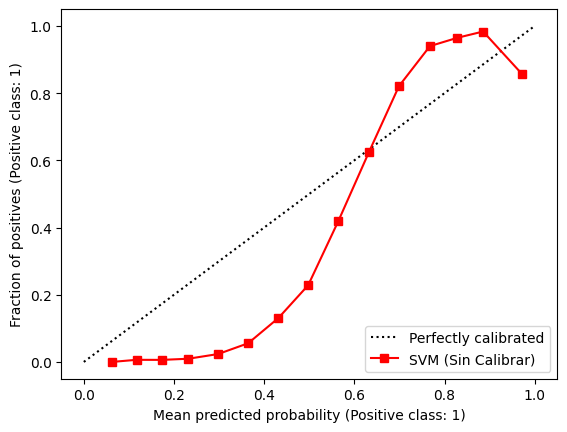

In [11]:
display_bad = CalibrationDisplay.from_predictions(
    y_test, y_pred_proba, n_bins=15, name="SVM (Sin Calibrar)", color="red"
)

Notamos que la curva de calibración es muy mala:

- Zona Baja: La curva se mantiene "pegada al piso". Aunque el modelo predice probabilidades que suben hasta 0.3 o 0.4, la realidad (eje Y) sigue siendo casi 0.
- Zona Alta: La curva se "pega al techo" muy rápido. Apenas el modelo predice 0.7, la realidad ya es casi 1.0 (100%).
- Zona Media: Hay un salto vertical abrupto.

Es decir, el modelo no tiene matices, es muy extremos en sus predicciones, los cuales nos hace predecir una probabilidad de clic de 0.3 cuando en realidad la realidad es de 0.05 por ejemplo. 

Desde una perspectiva de negocio, nos generá distorsiones del siguiente tipo:

**Caso 1:**
- Ingresa un usuario con probabilidad real de clic de 0.95. 
- El modelo predice 0.7, por lo que le ofrecemos menos a esta empresa que tiene su Ad. Por ejemplo, $1, porque no creemos que valga la pena gastar más en la subasta dado que el usuario no tiene la mayor de las probabilidades de clic, es mejor ser conservador.
- Pero, dado que subestimamos, se pierde la subasta contra otra empresa que ofrece más, por lo que se pierde la oportunidad de generar ingresos, además la empresa pierde la oportunidad de mostrar su anuncio a un usuario que le interesa.

**Caso 2:**
- Ingresa un usuario con probabilidad real de clic de 0.05 (es tráfico basura, un bot). 
- El modelo predice 0.3, es decir, bajo pero no es tan bajo como para no ofrecerle nada. 
- Se oferta $1.50 por algo que vale centavos. Se gana la subasta, pero se quema presupuesto en algo que no valía nada. 

Para llevar esto a un número, calculemos el Brier Score:

In [12]:
from sklearn.metrics import brier_score_loss

brier_bad = brier_score_loss(y_test, y_pred_proba)

print("Brier score del modelo: ", brier_bad)

Brier score del modelo:  0.10701500187685574


Este número por sí solo no indica mucho, pero nos permite medir qué tanto mejora cuando calibremos. Recordemos cuando más bajo mejor.

### Calibrando el modelo con Platt Scaling

Empecemos por Platt Scaling, que es un método que nos permite calibrar el modelo. Para ello, usamos a CalibratedClassifierCV de Scikit-Learn que nos resuelve el problema de calibración. 

¿Cómo funciona internamente? Básicamente, esta clase utiliza validación cruzada (Cross-Validation). Divide los datos de entrenamiento en varios folds: en cada iteración, entrena el modelo base con un grupo de datos y utiliza el grupo restante —que el modelo no vio— para ajustar la curva de calibración. Finalmente, la predicción que obtenemos es el promedio de las probabilidades de todos estos modelos calibrados.

Veamos el resultado:

In [13]:
from sklearn.calibration import CalibratedClassifierCV

In [14]:
model = Pipeline(
    steps=[
        ('scaler',StandardScaler()),
        ('model', LinearSVC(dual="auto", random_state=42))
    ]
)

calibrated_svc = CalibratedClassifierCV(model, method='sigmoid', cv=3)
calibrated_svc.fit(X_train, y_train)
y_pred_proba_calibrated_platt = calibrated_svc.predict_proba(X_test)[:, 1]

También podemos aplicar fácilmente la calibración isotónica 

Veamos el resultado:

In [15]:
model = Pipeline(
    steps=[
        ('scaler',StandardScaler()),
        ('model', LinearSVC(dual="auto", random_state=42))
    ]
)

calibrated_iso_svc = CalibratedClassifierCV(model, method='isotonic', cv=3)
calibrated_iso_svc.fit(X_train, y_train)
y_pred_proba_calibrated_iso = calibrated_iso_svc.predict_proba(X_test)[:, 1]

Con las dos calibraciones, veamos el Brier Score:

In [16]:
brier_platt = brier_score_loss(y_test, y_pred_proba_calibrated_platt)
brier_isotonic = brier_score_loss(y_test, y_pred_proba_calibrated_iso)

print("Brier score del modelo calibrado con Platt Scaling: ", brier_platt)
print("Brier score del modelo calibrado con Isotonic Regression: ", brier_isotonic)

print(f"Mejora de Platt Scaling: {((brier_bad - brier_platt)/brier_bad)*100:.1f}%")
print(f"Mejora de Isotonic Regression: {((brier_bad - brier_isotonic)/brier_bad)*100:.1f}%")

Brier score del modelo calibrado con Platt Scaling:  0.04965425900918288
Brier score del modelo calibrado con Isotonic Regression:  0.04962388121896015
Mejora de Platt Scaling: 53.6%
Mejora de Isotonic Regression: 53.6%


Ambas muestran un score similar, y más importante, menor que el del modelo original. Ahora veamos la curva de calibración:

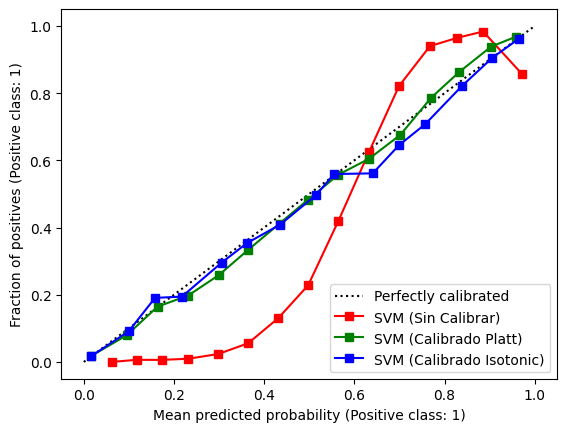

In [17]:
fig, ax = plt.subplots()

CalibrationDisplay.from_predictions(
    y_test, y_pred_proba, n_bins=15, name="SVM (Sin Calibrar)", color="red", ax=ax
)
CalibrationDisplay.from_predictions(
    y_test, y_pred_proba_calibrated_platt, n_bins=15, name="SVM (Calibrado Platt)", color="green", ax=ax
)
CalibrationDisplay.from_predictions(
    y_test, y_pred_proba_calibrated_iso, n_bins=15, name="SVM (Calibrado Isotonic)", color="blue", ax=ax
);

Aqui se observa que ambos calibrados mejoraron significativamente la curva de calibración. Ahora Platt es un poco mejor que Isotonic pero la diferencia es pequeña.

Ahora, surge la pregunta, pero las métricas del modelo calibrado cambiaron con respecto a las del modelo no calibrado?

Veamos:

In [18]:
print("Reporte de clasificación del modelo SVC sin calibrar:")
print(report_svc)

Reporte de clasificación del modelo SVC sin calibrar:
              precision    recall  f1-score   support

           0       0.94      0.99      0.96     26889
           1       0.80      0.50      0.62      3111

    accuracy                           0.94     30000
   macro avg       0.87      0.74      0.79     30000
weighted avg       0.93      0.94      0.93     30000



In [19]:
y_pred_platt = calibrated_svc.predict(X_test)
report = classification_report(y_test, y_pred_platt)

print("Reporte de clasificación del modelo SVC calibrado con Platt Scaling:")
print(report)

Reporte de clasificación del modelo SVC calibrado con Platt Scaling:
              precision    recall  f1-score   support

           0       0.95      0.98      0.97     26889
           1       0.78      0.54      0.64      3111

    accuracy                           0.94     30000
   macro avg       0.86      0.76      0.80     30000
weighted avg       0.93      0.94      0.93     30000



In [20]:
y_pred_iso = calibrated_iso_svc.predict(X_test)
report = classification_report(y_test, y_pred_iso)

print("Reporte de clasificación del modelo SVC calibrado con Isotonic Regression:")
print(report)

Reporte de clasificación del modelo SVC calibrado con Isotonic Regression:
              precision    recall  f1-score   support

           0       0.95      0.98      0.96     26889
           1       0.76      0.56      0.64      3111

    accuracy                           0.94     30000
   macro avg       0.85      0.77      0.80     30000
weighted avg       0.93      0.94      0.93     30000



Como vemos, no cambiaron nada las métricas del modelo, solo que ahora tenemos una curva de calibración que nos permite ver que el modelo está bien calibrado y es capaz de predecir correctamente la probabilidad de clic, lo cual nos da seguridad de que le vamos a decir a nuestros clientes que correctamente hagan las subastas y los resultados que obtengan sean los esperados.


---
## Usando un modelo que ya está calibrado

Supongamos que en vez de calibrar el modelo que nos dio nuestro colega, decidimos usar un modelo que no necesita de calibración: La regresión logística. 

Veamos el resultado:


In [21]:
from sklearn.linear_model import LogisticRegression

In [23]:
model_lr = Pipeline(
    steps=[
        ('scaler',StandardScaler()),
        ('model', LogisticRegression(random_state=42))
    ]
)

model_lr.fit(X_train, y_train)

y_pred = model_lr.predict(X_test)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.95      0.98      0.96     26889
           1       0.77      0.54      0.63      3111

    accuracy                           0.94     30000
   macro avg       0.86      0.76      0.80     30000
weighted avg       0.93      0.94      0.93     30000



Vemos que a nivel métricas no es muy diferentes a las del SVM usado previamente. Esto es probablemente porque ambos modelos ajustan una frontera lineal. 

Veamos ahora a nivel de calibración...

In [24]:
y_pred_proba_lr = model_lr.predict_proba(X_test)[:, 1]

brier_lr = brier_score_loss(y_test, y_pred_proba_lr)

print("Brier score del modelo SVM sin calibrar: ", brier_bad)
print("Brier score del modelo calibrado con Platt Scaling: ", brier_platt)
print("Brier score del modelo calibrado con Isotonic Regression: ", brier_isotonic)
print("Brier score de la regresión logística: ", brier_lr)

Brier score del modelo SVM sin calibrar:  0.10701500187685574
Brier score del modelo calibrado con Platt Scaling:  0.04965425900918288
Brier score del modelo calibrado con Isotonic Regression:  0.04962388121896015
Brier score de la regresión logística:  0.04969429012818136


A nivel de Brier Score, no vemos diferencia entre la regresión logística y el modelo de SVM calibrado.

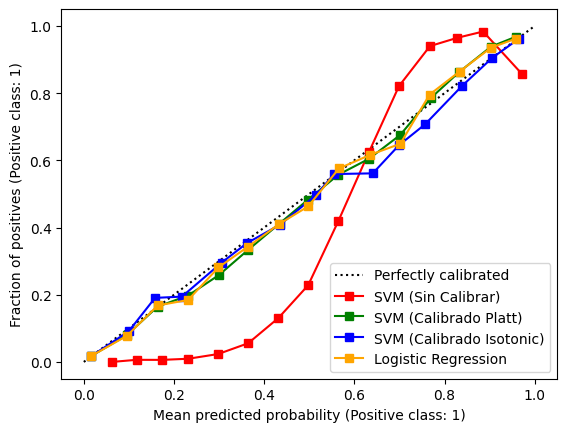

In [26]:
fig, ax = plt.subplots()

CalibrationDisplay.from_predictions(
    y_test, y_pred_proba, n_bins=15, name="SVM (Sin Calibrar)", color="red", ax=ax
)
CalibrationDisplay.from_predictions(
    y_test, y_pred_proba_calibrated_platt, n_bins=15, name="SVM (Calibrado Platt)", color="green", ax=ax
)
CalibrationDisplay.from_predictions(
    y_test, y_pred_proba_calibrated_iso, n_bins=15, name="SVM (Calibrado Isotonic)", color="blue", ax=ax
);
CalibrationDisplay.from_predictions(
    y_test, y_pred_proba_lr, n_bins=15, name="Logistic Regression", color="orange", ax=ax
);

Y para validar, la curva de calibración muestra el buen ajuste de la regresión logística.